In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from fastai.tabular.all import *
from multiprocessing import Pool
from sklearn.model_selection import KFold, GroupKFold
import lightgbm as lgb
from optiver_features import *
import pickle

In [4]:
df = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
time_ids = df.time_id.unique()

np.random.shuffle(time_ids)

splt = int(len(time_ids)*.7)
train_ids, test_ids = time_ids[:splt], time_ids[splt:]

len(train_ids), len(test_ids)

(2681, 1149)

In [5]:
len(df[df.time_id.isin(train_ids)]) / len(df)

0.6999967360793785

## Generate 5m dataset

In [6]:
book_feature_dict = {
    wap1: [],
    wap2: [],
    log_return1: [np.std],
    log_return2: [np.std],
  
    price_spread:[np.mean],
    total_volume:[np.mean],
}
trade_feature_dict = {
        log_return_price: [np.std],
        'seconds_in_bucket':[np.size],
        'size':[np.sum],
        'order_count':[np.sum],
}
time_id_features=[]
time_id_aggregations = []
stock_id_features = []
stock_id_aggregations = [time_id_aggregations]
time_windows = [(0,300), (0,100), (100,200), (200,300)]

In [7]:
def generate_0_to_5():


    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
    train_df5m = ofg.generate_train_df()
    ofg_targ =OptiverFeatureGenerator({wap1:[], log_return1:[realized_volatility]}, {'seconds_in_bucket':[np.size]}, [(300,600)], [],[],[],[])
    targ_df = ofg_targ.generate_train_df()
    train_df5m.target = targ_df.log_return1_realized_volatility_300_600
    train_df5m.target = train_df5m.target.replace(0, train_df5m.target.mean())
    return train_df5m
    

In [8]:
%%time
train_df5m = generate_0_to_5()

CPU times: user 1.73 s, sys: 401 ms, total: 2.13 s
Wall time: 3min 26s


In [8]:

train_df5m.to_feather('train_5m.feather')

In [9]:
def rename_col(x):
    return x.replace('300', '600').replace('200', '500').replace('100', '400').replace('_0', '_300')
def rename_col_back(x):
    return x.replace('300', '0').replace('400', '100').replace('500', '200').replace('600', '300')

def generate_5_to_10():
    tw = [(x+300, y+300) for x,y in time_windows]
    time_id_feat = [rename_col(x) for x in time_id_features]
    stock_id_feat = [rename_col(x) for x in stock_id_features]
    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, tw, time_id_feat,time_id_aggregations, stock_id_feat, stock_id_aggregations)

    df = ofg.generate_train_df()
    df.columns = [rename_col_back(x) for x in df.columns]
    return df

In [10]:
train_df5_10m  = generate_5_to_10()

In [10]:
train_df5_10m.to_feather('train_5_10.feather')

## LGBM Baseline

In [105]:
def rmspe_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe_np(y_true, y_pred), False

def train_models(train):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    x = train
    # Split features and target
    for c in ['row_id', 'target', 'time_id']:
        if c in x.columns:
            x = x.drop(c, axis=1)
    
    y = train['target']
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    models =[]
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create a KFold object
    kfold = GroupKFold()
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x, groups = train.time_id)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 3000, 
                          early_stopping_rounds = 25, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        models.append(model)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        #test_predictions += model.predict(x_test) / 10
        
    rmspe_score = rmspe_np(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return models

In [12]:
_=train_models(train_df5m)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000354804	training's RMSPE: 0.242644	valid_1's rmse: 0.00036763	valid_1's RMSPE: 0.251844
[200]	training's rmse: 0.000346954	training's RMSPE: 0.237275	valid_1's rmse: 0.000364846	valid_1's RMSPE: 0.249937
[300]	training's rmse: 0.000342559	training's RMSPE: 0.234269	valid_1's rmse: 0.000363361	valid_1's RMSPE: 0.248919
[400]	training's rmse: 0.00033941	training's RMSPE: 0.232116	valid_1's rmse: 0.000362797	valid_1's RMSPE: 0.248533
[500]	training's rmse: 0.000337037	training's RMSPE: 0.230493	valid_1's rmse: 0.000362461	valid_1's RMSPE: 0.248303
Early stopping, best iteration is:
[496]	training's rmse: 0.000337115	training's RMSPE: 0.230546	valid_1's rmse: 0.000362437	valid_1's RMSPE: 0.248286
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000355638	training's RMSPE: 0.242712	valid_1's rmse: 0.000371178	valid_1's RMSPE: 0.256355
[200]	training's 

## Learning embeddings

In [13]:
cont_nn,cat_nn = cont_cat_split(train_df5m, max_card=9000, dep_var='target')
cat_nn = ['time_id', 'stock_id']


procs_nn = [Categorify, FillMissing,Normalize]

splits = RandomSplitter(valid_pct=0.1,seed=43)(train_df5m)

dls = TabularPandas(train_df5m, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

def rmse(preds, targs):
    x = (targs-preds)
    return (x**2).mean().sqrt()

def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[.5,.2,0], 'embed_p':0.5, }
learn = tabular_learner(dls, y_range=(0,.1), layers=[200,100,40], emb_szs={'stock_id':10, 'time_id':10}, 
                        n_out=1, 
                        loss_func = rmspe, 
                        
                        metrics=AccumMetric(rmspe), config=config)

In [14]:
learn.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,rmspe,time
0,17.311615,16.506012,16.507843,00:08
1,12.629494,11.702081,11.703773,00:03
2,7.498426,6.349653,6.354630,00:03
3,2.725837,1.951894,1.959046,00:03
4,0.644878,0.445253,0.467625,00:03
5,0.567171,0.374760,0.396642,00:03
6,0.432339,0.285919,0.287847,00:03
7,0.329246,0.260905,0.261297,00:03
8,0.310724,0.247502,0.247896,00:03
9,0.278522,0.244431,0.244935,00:03


In [15]:
torch.save(learn.model.embeds[0].weight.data, 'timeemb10.pt')

In [15]:
categorify = dls.procs[2]
time_embs = learn.model.embeds[0].weight.data.cpu()
stock_embs = learn.model.embeds[1].weight.data.cpu()

In [16]:
def append_embs(data_df, categorify, time_embs, stock_embs):
    time_id_embs = dict()
    for idx, time_id in enumerate(categorify.classes['time_id']):
        time_id_embs[time_id] = time_embs[idx].tolist()

    stock_id_embs = dict()
    for idx, stock_id in enumerate(categorify.classes['stock_id']):
        stock_id_embs[stock_id] = stock_embs[idx].tolist()

    all_embs = []
    for _, row in (data_df[['stock_id', 'time_id']].iterrows()):
        emb1 = stock_id_embs[row.stock_id]
        emb2 = time_id_embs[row.time_id]
        all_embs.append(emb1+emb2)
    columns = [f'stock_emb{i}' for i in range(stock_embs.shape[1])] +[f'time_emb{i}' for i in range(time_embs.shape[1])]
    embs_df = pd.DataFrame(all_embs, columns=columns)

    return pd.concat([data_df, embs_df], axis=1)

In [17]:
test_df = train_df5_10m
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)
preds5_10 = preds.view(-1).numpy()

## Train 5m LGBM with embeddings


In [18]:
train_5_with_embs = append_embs(train_df5m, categorify, time_embs, stock_embs)



In [19]:
_=train_models(train_5_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000323298	training's RMSPE: 0.221097	valid_1's rmse: 0.000334843	valid_1's RMSPE: 0.229383
[200]	training's rmse: 0.000315192	training's RMSPE: 0.215554	valid_1's rmse: 0.000331227	valid_1's RMSPE: 0.226906
[300]	training's rmse: 0.000311048	training's RMSPE: 0.21272	valid_1's rmse: 0.000329867	valid_1's RMSPE: 0.225975
[400]	training's rmse: 0.000307874	training's RMSPE: 0.210549	valid_1's rmse: 0.000329082	valid_1's RMSPE: 0.225437
[500]	training's rmse: 0.000305411	training's RMSPE: 0.208865	valid_1's rmse: 0.000328675	valid_1's RMSPE: 0.225158
Early stopping, best iteration is:
[515]	training's rmse: 0.000305187	training's RMSPE: 0.208711	valid_1's rmse: 0.000328561	valid_1's RMSPE: 0.225079
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.0003236	training's RMSPE: 0.220847	valid_1's rmse: 0.000338292	valid_1's RMSPE: 0.233642
[200]	training's r

## Baseline LGMB 10m

In [69]:
time_windows = list(zip(range(0,601,100), [600]*6))
time_windows

[(0, 600), (100, 600), (200, 600), (300, 600), (400, 600), (500, 600)]

In [49]:
#time_windows = [(0,600)] +list(zip(range(0,601,100), range(100,601,100)))
#time_windows = [(0,600), (300,600)]

In [70]:
agg_cols = ['log_return_price_std', 'log_return1_std', 'log_return2_std']

In [71]:
time_id_features = [f'{col}_{x}_{y}' for x,y in time_windows for col in agg_cols] 
time_id_aggregations = ['mean', 'std', 'min' ]
stock_id_features = time_id_features
stock_id_aggregations = time_id_aggregations

In [72]:
ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
df = ofg.generate_train_df()



In [73]:
#df = pd.read_feather('train_10m.feather')

In [74]:
train_df10m = df[df.time_id.isin(train_ids)].reset_index()
test_df10m = df[df.time_id.isin(test_ids)].reset_index()
len(train_df10m), len(test_df10m)

(300251, 128681)

In [76]:
models=train_models(train_df10m)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000457726	training's RMSPE: 0.212252	valid_1's rmse: 0.000485175	valid_1's RMSPE: 0.222866
[200]	training's rmse: 0.000437764	training's RMSPE: 0.202995	valid_1's rmse: 0.000482336	valid_1's RMSPE: 0.221562
Early stopping, best iteration is:
[210]	training's rmse: 0.000436285	training's RMSPE: 0.20231	valid_1's rmse: 0.000481833	valid_1's RMSPE: 0.221331
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000465024	training's RMSPE: 0.213102	valid_1's rmse: 0.00048264	valid_1's RMSPE: 0.23202
Early stopping, best iteration is:
[108]	training's rmse: 0.000462848	training's RMSPE: 0.212105	valid_1's rmse: 0.000482041	valid_1's RMSPE: 0.231732
Training fold 3
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000456197	training's RMSPE: 0.212227	valid_1's rmse: 0.000496956	valid_1's RMSPE: 0.225239
[200]	training's rmse:

In [77]:
test_pred = np.zeros(len(test_df10m))
for model in models:
    pred = model.predict(test_df10m.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

baseline_score = rmspe_np(test_df10m.target, test_pred)
baseline_score

0.22513449599523208

## LGBM 10m with trained embeddings

In [78]:
df_with_embs = append_embs(df, categorify, time_embs, stock_embs)

In [79]:
df_with_embs['5m_pred']= preds5_10

In [80]:
# to_drop = [x for x in df_with_embs.columns if x.endswith('_stock') or x.endswith('_time')]

# df_with_embs = df_with_embs.drop(to_drop, axis=1)

In [81]:
train_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(train_ids)].reset_index()
test_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(test_ids)].reset_index()

In [82]:
# train_10m_with_embs.to_feather('train_10m_with_embs.feather')
# test_10m_with_embs.to_feather('test_10m_with_embs.feather')

In [96]:
train_10m_with_embs.to_feather('train_182cols.feather')
test_10m_with_embs.to_feather('test_182cols.feather')

In [97]:
cols_to_keep = ['log_return2_std_0_600',
 'log_return_price_std_0_600',
 '5m_pred',
 'stock_id',
 'time_emb0',
 'time_emb1',
 'time_emb2',
 'time_emb3',
 'time_emb4',
 'time_emb5',
 'time_emb6',
 'time_emb7',
 'time_emb8',
 'time_emb9',
 'order_count_sum_0_600',
 'seconds_in_bucket_size_0_600',
 'size_sum_0_600',
 'log_return1_std_0_600_min_time',
 'log_return1_std_0_600_mean_time',
 'log_return1_std_0_600_min_stock',
 'log_return1_std_0_600_mean_stock',
 'log_return1_std_0_600',
 'log_return1_std_100_600',
 'log_return1_std_200_600',
 'log_return1_std_300_600',
 'log_return1_std_400_600',
 'log_return1_std_500_600',
 'price_spread_mean_0_600',
 'log_return_price_std_0_600_mean_time',
 'log_return_price_std_100_600_mean_time',
 'log_return_price_std_200_600_mean_time',
 'log_return_price_std_300_600_mean_time',
 'log_return_price_std_400_600_mean_time',
 'log_return_price_std_500_600_mean_time',
 'log_return_price_std_0_600_min_time',
 'log_return_price_std_100_600_min_time',
 'log_return_price_std_200_600_min_time',
 'log_return_price_std_300_600_min_time',
 'log_return_price_std_400_600_min_time',
 'log_return_price_std_500_600_min_time',
 'total_volume_mean_0_600']

In [107]:
models=train_models(train_10m_with_embs[cols_to_keep+['target', 'time_id']])

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000455463	training's RMSPE: 0.211202	valid_1's rmse: 0.000477484	valid_1's RMSPE: 0.219333
[200]	training's rmse: 0.000438723	training's RMSPE: 0.20344	valid_1's rmse: 0.000474947	valid_1's RMSPE: 0.218168
Early stopping, best iteration is:
[197]	training's rmse: 0.00043922	training's RMSPE: 0.20367	valid_1's rmse: 0.000474725	valid_1's RMSPE: 0.218066
Training fold 2
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[72]	training's rmse: 0.000470515	training's RMSPE: 0.215618	valid_1's rmse: 0.000465972	valid_1's RMSPE: 0.224007
Training fold 3
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000455943	training's RMSPE: 0.212109	valid_1's rmse: 0.000493327	valid_1's RMSPE: 0.223594
[200]	training's rmse: 0.000438512	training's RMSPE: 0.204	valid_1's rmse: 0.000486984	valid_1's RMSPE: 0.220719
[300]	training's rmse: 0.0

In [108]:
test_pred = np.zeros(len(test_10m_with_embs))
for model in models:
    #pred = model.predict(test_10m_with_embs.drop(['row_id', 'time_id', 'target'], axis=1)) 
    pred = model.predict(test_10m_with_embs[cols_to_keep]) 
    test_pred += pred /5

embeds5mpred_score = rmspe_np(test_10m_with_embs.target, test_pred)
embeds5mpred_score

0.22261434022102783

In [109]:
(baseline_score-embeds5mpred_score)/ baseline_score

0.01119400100399374

In [110]:
# for m in models[:2]:
#     lgb.plot_importance(m, max_num_features=20)

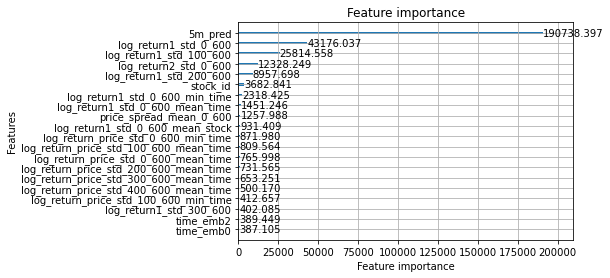

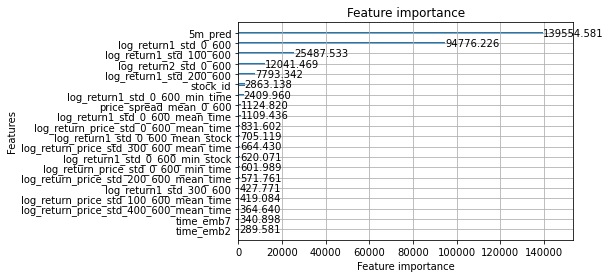

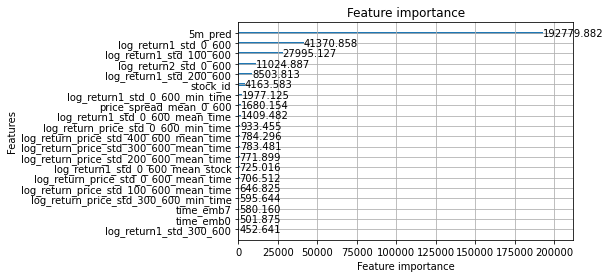

In [111]:
for m in models[:3]:
    lgb.plot_importance(m, max_num_features=20, importance_type='gain')

## Train NN

In [41]:
#train_10m_with_embs = train_10m_with_embs.fillna(0)

In [113]:
splits = first(GroupKFold().split(train_10m_with_embs, groups = train_10m_with_embs.time_id))
splits = (list(splits[0]), list(splits[1]))

In [145]:
cont_nn,cat_nn = cont_cat_split(train_10m_with_embs[cols_to_keep+['target']], max_card=9000, dep_var='target')
cat_nn = []


procs_nn = [Categorify, FillMissing,Normalize]

#splits = RandomSplitter(valid_pct=0.2,seed=43)(train_10m_with_embs)

dls = TabularPandas(train_10m_with_embs[cols_to_keep+['target']], procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

def rmse(preds, targs):
    x = (targs-preds)
    return (x**2).mean().sqrt()

def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[0.5,0,0], }
learn = tabular_learner(dls, y_range=(0,.1), layers=[200,100,10], 
                        n_out=1, 
                        loss_func = rmspe, 
                        
                        metrics=AccumMetric(rmspe), config=config)

In [146]:
learn.fit_one_cycle(40, 5e-3, wd=.1)

epoch,train_loss,valid_loss,rmspe,time
0,13.516313,12.587500,12.596029,00:01
1,8.273132,6.517494,6.539475,00:01
2,3.046509,1.786598,1.810444,00:01
3,0.878389,0.696749,1.755828,00:01
4,0.616284,0.550174,1.699189,00:01
5,0.828290,0.471171,1.681832,00:01
6,0.326697,0.260644,0.263388,00:01
7,0.257812,0.232881,0.235092,00:01
8,0.256071,0.238392,0.241004,00:01
9,0.242561,0.231613,0.234122,00:01


In [147]:

test_dl = dls.test_dl(test_10m_with_embs[cols_to_keep])
preds, _ = learn.get_preds(dl=test_dl)

In [148]:
rmspe_np(test_10m_with_embs.target, preds.view(-1).numpy())

0.22095482563862506